In [16]:
import cv2
import numpy as np

# --- Step 1: Read and Preprocess Image ---
img = cv2.imread('/content/allwrong.jpeg')
if img is None:
    raise Exception("Image not found.")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 1)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# --- Step 2: Find Contours (Bubbles) ---
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bubble_contours = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if 500 < area < 1000:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        if 0.9 < aspect_ratio < 1.1:
            bubble_contours.append(cnt)

# --- Step 3: Sort Bubbles Vertically ---
def sort_contours(cnts):
    return sorted(cnts, key=lambda c: cv2.boundingRect(c)[1])

sorted_bubbles = sort_contours(bubble_contours)

# --- Step 4: Group Bubbles per Question ---
num_questions = 2
choices_per_question = 4
student_answers = {}
bubble_groups = []

for i in range(0, len(sorted_bubbles), choices_per_question):
    group = sorted_bubbles[i:i + choices_per_question]
    group = sorted(group, key=lambda c: cv2.boundingRect(c)[1])
    bubble_groups.append(group)

# --- Step 5: Detect Selected Choices ---
for question_index, group in enumerate(bubble_groups):
    selected = []
    for j, cnt in enumerate(group):
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        total = cv2.countNonZero(cv2.bitwise_and(thresh, thresh, mask=mask))

        if total > 300:
            selected.append(chr(65 + j))  # A, B, C, D

    student_answers[question_index + 1] = selected

# --- Step 6: Scoring ---
answer_key = {
    1: ["C"],
    2: ["B"]
}

score = 0
for q, correct in answer_key.items():
    selected = student_answers.get(q, [])
    if set(selected) == set(correct):
        score += 1

print("Student Answers:", student_answers)
print("Score:", score, "/", num_questions)


Student Answers: {1: ['A', 'B', 'D'], 2: ['C']}
Score: 0 / 2


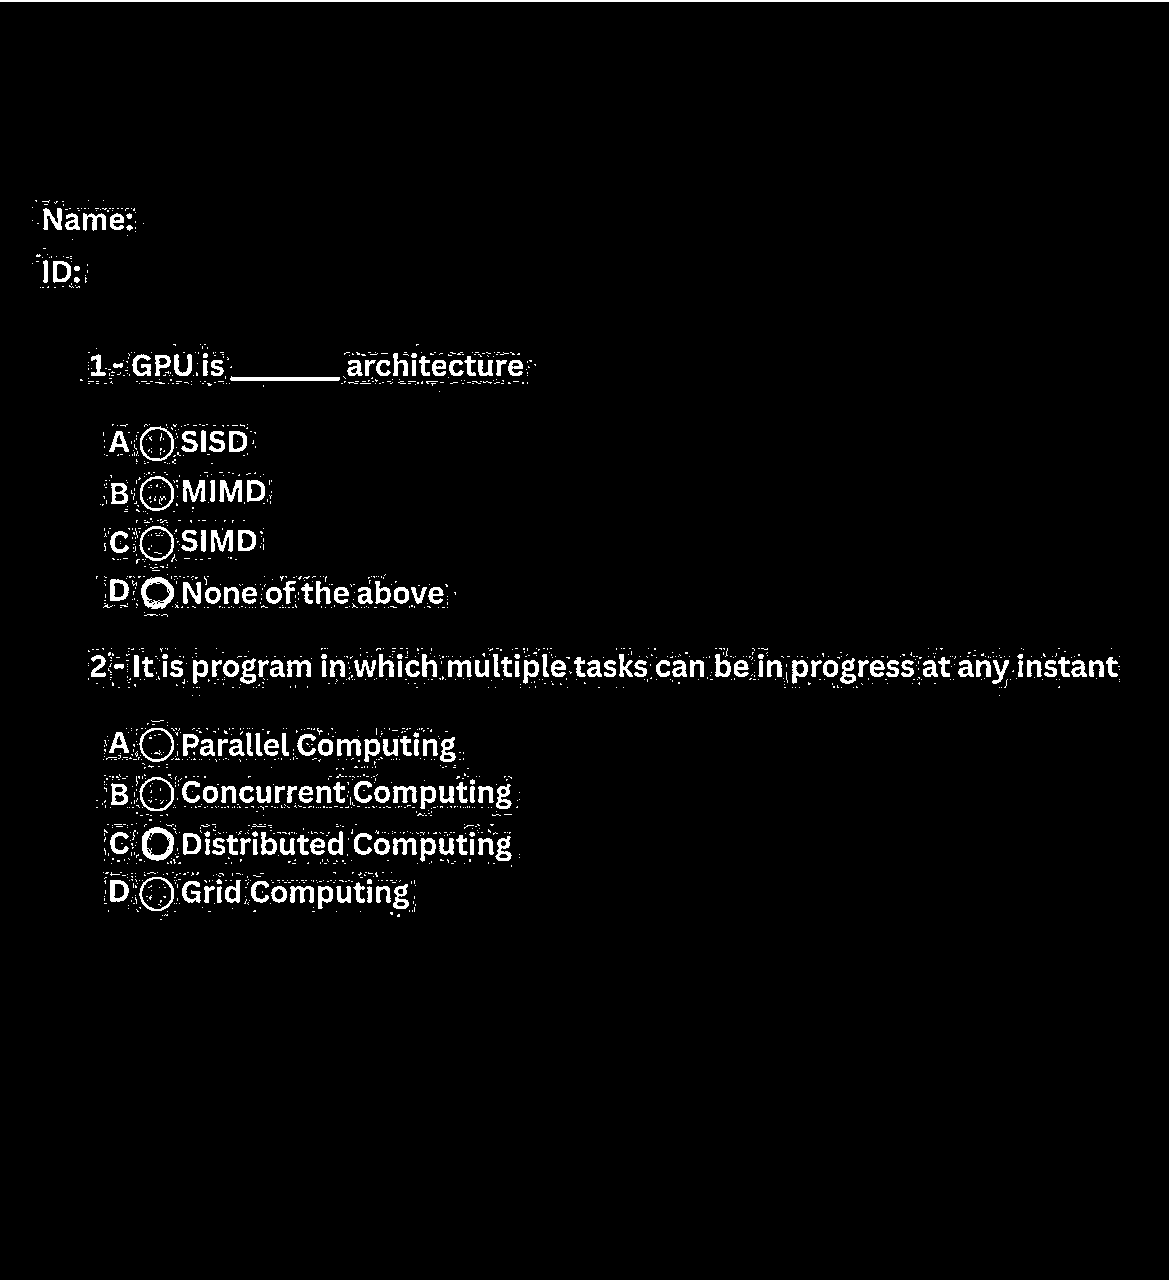

In [19]:
from google.colab.patches import cv2_imshow
cv2_imshow(thresh)